In [0]:
# Dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pickle
import warnings



In [9]:
os.environ['KAGGLE_USERNAME'] = "********"
os.environ['KAGGLE_KEY'] = "********" # key from the json file
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

100% 2.35G/2.37G [00:34<00:00, 104MB/s] 
100% 2.37G/2.37G [00:34<00:00, 73.4MB/s]


In [10]:
print(os.listdir())
!unzip -q weed-detection-in-soybean-crops.zip

['.config', 'weed-detection-in-soybean-crops.zip', 'sample_data']


In [12]:
print(os.listdir())

['.config', 'weed-detection-in-soybean-crops.zip', 'dataset', 'sample_data']


In [0]:
!rm -r ./dataset/broadleaf/*
!rm -r ./dataset/grass/*
!rm -r ./dataset/soil/*
!rm -r ./dataset/soybean/*

In [0]:
class Data_augmentation:
    def __init__(self, path, image_name):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.path = path
        self.name = image_name
        print(path+image_name)
        self.image = cv2.imread(path+image_name)

    def rotate(self, image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    
    def image_augment(self, save_path): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        img = self.image.copy()
        img_flip = self.flip(img, vflip=True, hflip=False)
        img_rot = self.rotate(img)
        #img_gaussian = self.add_GaussianNoise(img)
        
        name_int = self.name[:len(self.name)-4]
        cv2.imwrite(save_path+'%s' %str(name_int)+'_vflip.jpg', img_flip)
        cv2.imwrite(save_path+'%s' %str(name_int)+'_rot.jpg', img_rot)
        #cv2.imwrite(save_path+'%s' %str(name_int)+'_GaussianNoise.jpg', img_gaussian)

In [0]:
def main(file_dir,output_path):
        for root, _, files in os.walk(file_dir):
            print(root)
        for file in files:
            raw_image = Data_augmentation(root,file)
            raw_image.image_augment(output_path)

In [17]:
file_dir = './dataset/dataset/broadleaf/'
output_path = './dataset/broadleaf/'
main(file_dir=file_dir, output_path=output_path)

file_dir = './dataset/dataset/grass/'
output_path = './dataset/grass/'
main(file_dir=file_dir, output_path=output_path)

file_dir = './dataset/dataset/soil/'
output_path = './dataset/soil/'
main(file_dir=file_dir, output_path=output_path)

file_dir = './dataset/dataset/soybean/'
output_path = './dataset/soybean/'
main(file_dir=file_dir, output_path=output_path)

./dataset/dataset/broadleaf/
./dataset/dataset/broadleaf/262.tif
./dataset/dataset/broadleaf/332.tif
./dataset/dataset/broadleaf/179.tif
./dataset/dataset/broadleaf/422.tif
./dataset/dataset/broadleaf/144.tif
./dataset/dataset/broadleaf/945.tif
./dataset/dataset/broadleaf/1031.tif
./dataset/dataset/broadleaf/465.tif
./dataset/dataset/broadleaf/442.tif
./dataset/dataset/broadleaf/127.tif
./dataset/dataset/broadleaf/128.tif
./dataset/dataset/broadleaf/879.tif
./dataset/dataset/broadleaf/425.tif
./dataset/dataset/broadleaf/447.tif
./dataset/dataset/broadleaf/1006.tif
./dataset/dataset/broadleaf/872.tif
./dataset/dataset/broadleaf/504.tif
./dataset/dataset/broadleaf/304.tif
./dataset/dataset/broadleaf/616.tif
./dataset/dataset/broadleaf/266.tif
./dataset/dataset/broadleaf/104.tif
./dataset/dataset/broadleaf/835.tif
./dataset/dataset/broadleaf/452.tif
./dataset/dataset/broadleaf/1125.tif
./dataset/dataset/broadleaf/145.tif
./dataset/dataset/broadleaf/846.tif
./dataset/dataset/broadleaf/614.

Data Preprocessing

In [0]:
os.chdir('/content/')

classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
data_dir = r'./dataset/dataset/'
#data_dir = r'./dataset/'
directory = data_dir

In [0]:
pathname = os.path.join(directory,classes[0])
broadleaf = os.listdir(pathname)
pathname = os.path.join(directory,classes[1])
grass = os.listdir(pathname)
pathname = os.path.join(directory,classes[2])
soil = os.listdir(pathname)
pathname = os.path.join(directory,classes[3])
soybean = os.listdir(pathname)

In [20]:
# Number of images in the directories
print(classes[0] , str(len(broadleaf)))
print(classes[1] , str(len(grass)))
print(classes[2] , str(len(soil)))
print(classes[3] , str(len(soybean)))

broadleaf 1191
grass 3520
soil 3249
soybean 7376


In [0]:
def show_image(filename):
  image = plt.imread(filename,format='tif')
  fig, ax = plt.subplots()
  im = ax.imshow(image)
  plt.show()
  print(image.shape)

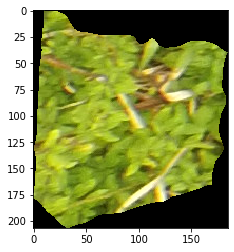

(207, 185, 3)


In [23]:
import json
import random
import cv2
import glob

filename = os.path.join(os.path.join(directory,classes[0]),broadleaf[random.randint(0,len(broadleaf))])
show_image(filename)

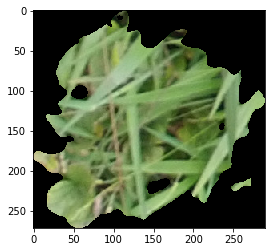

(272, 290, 3)


In [24]:
filename = os.path.join(os.path.join(directory,classes[1]),grass[random.randint(0,len(grass))])
show_image(filename)

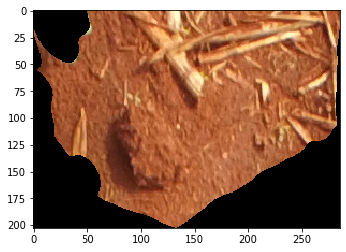

(203, 286, 3)


In [25]:
filename = os.path.join(os.path.join(directory,classes[2]),soil[random.randint(0,len(soil))])
show_image(filename)

In [0]:
num2class = {0: 'broadleaf', 
         1: 'grass', 
         2: 'soil', 
         3: 'soybean'}

class2num = {'broadleaf' : 0, 
         'grass' : 1, 
         'soil' : 2, 
         'soybean' : 3}

In [0]:
m = 1
num_file = 1100 * m
num_train = 1000 * m  
num_val = 50 * m
num_test = 50 * m

all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

In [0]:
# Image dimension
im_width = 200
im_height = 200 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(num_train*len(classes),im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(num_val*len(classes),im_width, im_height, im_channel), dtype=np.float64)
X_test = np.empty(shape=(num_test*len(classes),im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(num_train*len(classes))
y_val = np.empty(num_val*len(classes))
y_test = np.empty(num_test*len(classes)) 

for i, cls in enumerate(classes): 
    X_test[num_test*i:num_test*(i+1)] = X[np.where(Y == i)[0][:num_test]]
    X_val[num_val*i:num_val*(i+1)] = X[np.where(Y == i)[0][num_test:num_test+num_val]]
    X_train[num_train*i:num_train*(i+1)] = X[np.where(Y == i)[0][num_test+num_val:]]
    
    y_test[num_test*i:num_test*(i+1)] = i
    y_val[num_val*i:num_val*(i+1)] = i
    y_train[num_train*i:num_train*(i+1)] = i

del Y 
del X

In [29]:
X_train.shape

(4000, 200, 200, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


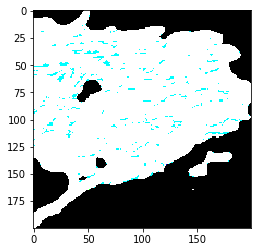

In [30]:
plt.imshow(X_train[500])



In [31]:
# Extract features 
#Shuffle training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

#Subtract out the mean image 
#first: compute the mean image
mean_image = np.mean(X_train, axis=0) #axis=0. stack horizontally
#mean_image = 128
#mean_image = 0
#Second subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

#Third append the bias dimension using linear algebra trick
#Not for net
# X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
# X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
# X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
# X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
# X_tiny = np.hstack([X_tiny, np.ones((X_tiny.shape[0], 1))])

print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)


X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)
X_dev shape (500, 120000) | y_dev shape: (500,)
X_tiny shape (10, 120000) | y_tiny shape: (10,)
=====STACK BIAS term=====
X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


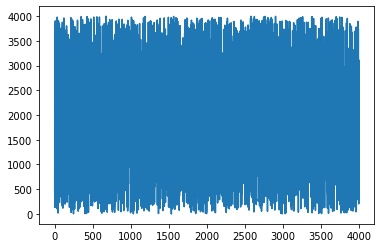

In [32]:
plt.plot(train_idxs)
plt.show()

In [0]:
# Visualize some images 
# Make sure that everything when OK
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4

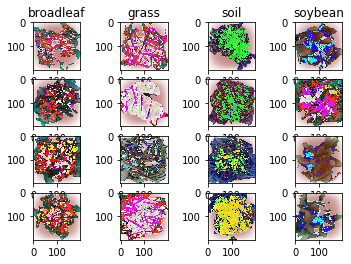

In [34]:
# show some train images
for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

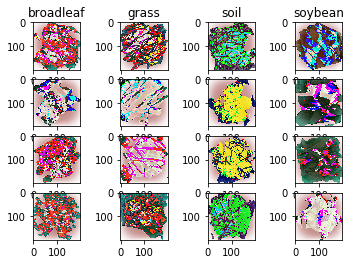

In [35]:
# show some dev images
for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_dev)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_dev[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

In [0]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        #DEfine relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N


        #Want to find dW2(dL/dW2)
        # Derivation: dL/dW2 = dL/dscore * dscore/dW2(chain rule)
        #dL/dscore = softmax since L(score) = softmax(variable)
        #dscore/dW2 = relu_(hidden layer output)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        #dL/dW1 = dL/dscore * dscore/drelu(layler1) * drelu(layer1)/dW1 
        #dL/dW1 = dW1 = softmax * W2 * X 
        hidden = softmax.dot(W2.T)

        #derivative of a max gate
        #Intuition: in forward pass if neuron didn't fire that mean. the derivative of that neuron 
        # is 0. This might be bad since this will kill gradient. 
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):
        '''
        Train using SGD 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [37]:
input_size = im_width * im_height * im_channel
hidden_size = 200
output_size = n_class 
std = 1e-3 # size initialization parameter

net = TwoLayerNet(input_size, hidden_size,output_size,std )
#stats = net.train(X_dev, y_dev, X_val, y_val, 
#              learning_rate =1e-5, learning_rate_decay=0.95, 
#              reg=0.0, num_iters=140, 
#              batch_size=100, it_verbose = 10,verbose=True)
stats = net.train(X_train, y_train, X_val, y_val, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, num_iters=300, 
              batch_size=100, it_verbose = 10,verbose=True)

iteration: 0 / 300 | Loss: 1.392551
iteration: 10 / 300 | Loss: 1.375881
iteration: 20 / 300 | Loss: 1.371506
iteration: 30 / 300 | Loss: 1.302637
iteration: 40 / 300 | Loss: 1.282157
iteration: 50 / 300 | Loss: 1.258179
iteration: 60 / 300 | Loss: 1.220045
iteration: 70 / 300 | Loss: 1.186919
iteration: 80 / 300 | Loss: 1.152574
iteration: 90 / 300 | Loss: 1.077655
iteration: 100 / 300 | Loss: 1.081671
iteration: 110 / 300 | Loss: 1.133209
iteration: 120 / 300 | Loss: 1.060384
iteration: 130 / 300 | Loss: 1.058943
iteration: 140 / 300 | Loss: 1.062191
iteration: 150 / 300 | Loss: 0.964967
iteration: 160 / 300 | Loss: 0.989162
iteration: 170 / 300 | Loss: 0.916074
iteration: 180 / 300 | Loss: 0.919558
iteration: 190 / 300 | Loss: 0.945374
iteration: 200 / 300 | Loss: 0.852494
iteration: 210 / 300 | Loss: 0.884135
iteration: 220 / 300 | Loss: 0.869621
iteration: 230 / 300 | Loss: 0.834476
iteration: 240 / 300 | Loss: 0.886921
iteration: 250 / 300 | Loss: 0.883115
iteration: 260 / 300 | 

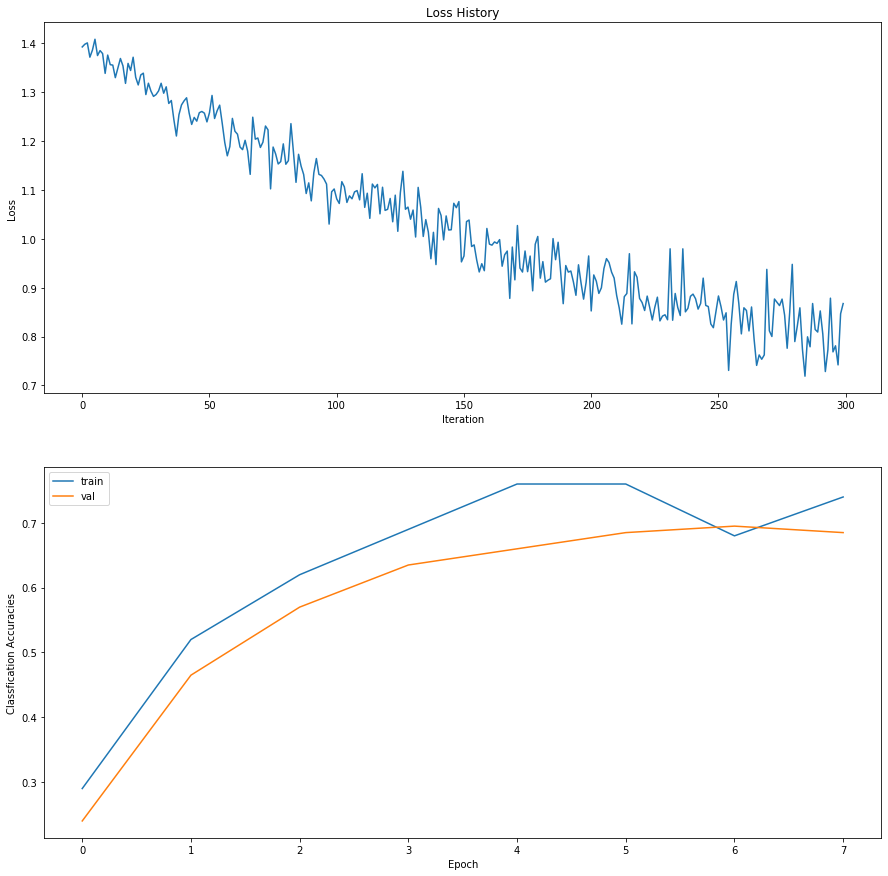

In [38]:


# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats['train_acc_hist'], label='train')
plt.plot(stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()



In [40]:

len(all_files)



4400

In [41]:
X_train.shape, X_dev.shape, X_test.shape, X_tiny.shape

((4000, 120000), (500, 120000), (200, 120000), (10, 120000))

In [42]:
# Shapes Y
y_train.shape, y_dev.shape, y_test.shape, y_tiny.shape

((4000,), (500,), (200,), (10,))

Prediction of Random Image

In [0]:
# predict a random image
def predict_random_image():
  # Choose an image
  idx = random.randint(0,len(y_dev))
  # Preprozess image
  plt.imshow((X_dev[idx]+mean_image).reshape(im_width, im_height, im_channel).astype('uint8'))
  plt.title(num2class[y_dev[idx]])
  plt.show()
  # Make the prediction
  result = net.predict(X_dev[idx].reshape(-1,X_dev[idx].shape[0]))
  print("Prediction: ", num2class[np.asscalar(result)])

In [0]:
plt.rcParams['figure.figsize'] = (11.0, 9.0) # set default size of plots

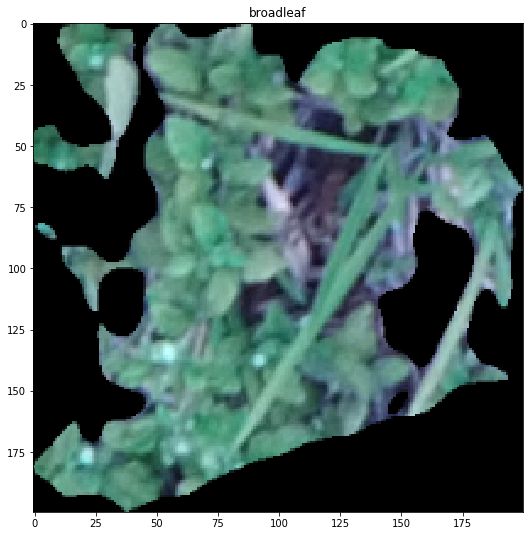

Prediction:  soybean


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


In [45]:
predict_random_image()

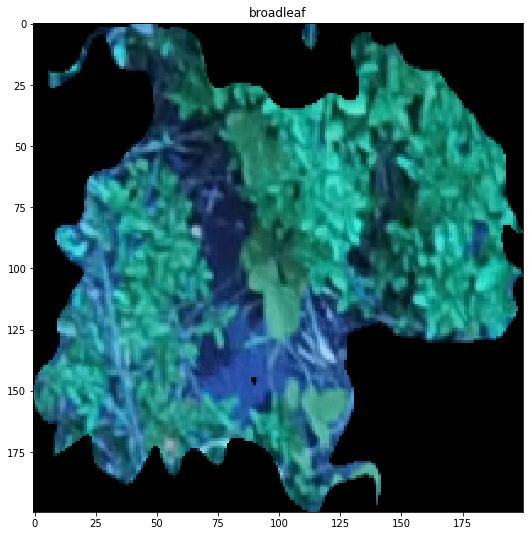

Prediction:  broadleaf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


In [46]:
predict_random_image()

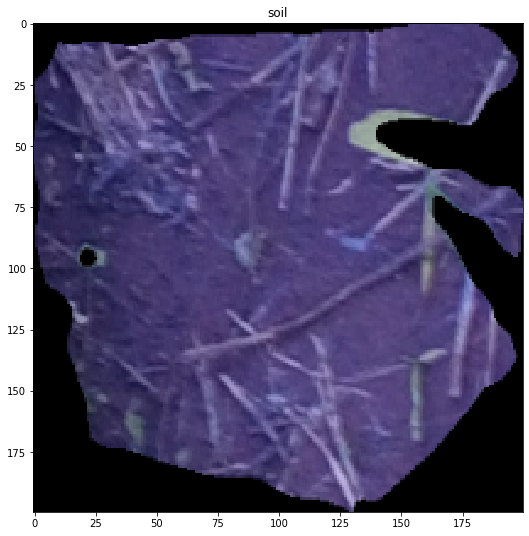

Prediction:  soil


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


In [47]:
predict_random_image()